In [71]:
import numpy as np
import pandas as pd
import main
las_data = pd.read_csv(main.csv_out_file, delimiter=';')
# удаляем скважины, по которым нет водонасыщенности
well_name_list = las_data['well_name'].value_counts().index.tolist()
for well_name in well_name_list:
    well_data = las_data[las_data['well_name'] == well_name]
    if np.isnan(well_data['kvo'].mean()) or np.isnan(well_data['rp'].mean()) or np.isnan(well_data['kgl'].mean()):
        # axis  = 0, удаляем столбцы
        las_data = las_data.drop(las_data[las_data['well_name'] == well_name].index, axis = 0)

In [72]:
# ситчает среднее значение параметра по высоте с пропусклм nan
def calc_mean_value_by_h(h_arr, val_arr):
    hv_sum = 0.
    h_sum = 0.
    prev_nan_val = False
    for h, val in zip(h_arr, val_arr):
        if not(np.isnan(h)) and not(np.isnan(val)):
            h_sum += h
            hv_sum += h * val

    # print(h_sum, hv_sum)
    return hv_sum/h_sum

In [73]:
# получим нефтенасыщенность
las_data['kno'] = 1 - las_data['kvo']

In [74]:
# переведем данные с 0 в 1 
from sklearn.preprocessing import MinMaxScaler
# уберем Nan
las_data = las_data.ffill()
# las_data_norm=las_data.copy()
# las_data_norm['aps'] = MinMaxScaler().fit_transform(las_data['aps'])
# # las_data_norm['rp'] = MinMaxScaler().fit_transform(las_data['rp'])
# las_data_norm['kp'] = MinMaxScaler().fit_transform(las_data['kp'])
# las_data_norm['kgl'] = MinMaxScaler().fit_transform(las_data['kgl'])
# las_data_norm['kpr'] = MinMaxScaler().fit_transform(las_data['kpr'])
# las_data_norm['kvo'] = MinMaxScaler().fit_transform(las_data['kvo'])
# las_data_norm['kng'] = MinMaxScaler().fit_transform(las_data['kng'])
# # Применить нормализацию к данным
# las_data=las_data_norm

In [75]:
# заполним данные по скважинам
well_name_list = las_data['well_name'].value_counts().index.tolist()
data_well_for_analize = pd.DataFrame() 
first = True
kno_list = []
kgl_list = []
rp_list = []
for well_name in well_name_list:
    # print(well_name)
    data_well_list = []
    # Выделяем даные для одной скважины
    data_well = las_data[las_data['well_name'] == well_name]
    kno_list.append(calc_mean_value_by_h(data_well['DEPT'],data_well['kno']))
    kgl_list.append(calc_mean_value_by_h(data_well['DEPT'],data_well['kgl']))
    rp_list.append(calc_mean_value_by_h(data_well['DEPT'],data_well['rp']))
    

data_well_for_analize = pd.DataFrame({'well_name':well_name_list, 'kno':kno_list,
                                      'kgl':kgl_list, 'rp':rp_list})
data_well_for_analize.head()

,kgl,kno,rp,well_name
0,0.225966,0.149524,36.506476,4R
1,0.216458,0.239250,6.252875,643PL
2,0.304413,0.256349,3.837315,3WZ
3,0.300933,0.260787,4.941306,4WZ
4,0.199969,0.151872,20.670716,554


In [76]:
data_well_for_analize['kno'].describe()

count    213.000000
mean       0.081278
std        0.057889
min        0.000000
25%        0.044492
50%        0.069674
75%        0.099130
max        0.420841
Name: kno, dtype: float64

In [77]:
# добавляем wc
water_content_data = pd.read_csv(main.data_dir + "\\res.csv", delimiter=';')
water_content_data = water_content_data.rename(columns={'Скважина': main.keys_dict[main.kid_well]})
water_content_data = water_content_data.rename(columns={' Начальная обводненность ': 'wc'})
water_content_data = water_content_data.rename(columns={'Дата запуска': 'date_start'})
# del water_content_data['Дата запуска']
data_for_analize = pd.merge(data_well_for_analize, water_content_data, on=main.keys_dict[main.kid_well])
data_for_analize.head()

,kgl,kno,rp,well_name,date_start,wc
0,0.225966,0.149524,36.506476,4R,01.02.2014,0.52
1,0.199969,0.151872,20.670716,554,01.06.2008,0.08
2,0.232420,0.086677,14.251230,519,01.04.2010,0.16
3,0.240289,0.048303,15.514748,529,01.03.2010,0.37
4,0.205232,0.061510,30.065659,536,01.08.2009,0.26


In [78]:
# оставлеям только данные для x и y отдельно
y = data_for_analize['wc']
well_names = data_for_analize['well_name']
data_for_analize.drop(['wc', 'well_name', 'date_start'], axis=1, inplace=True)
# округлим вектор ответов
y_r = int(10) * round(y,1)
y_r = list(map(int, y_r))

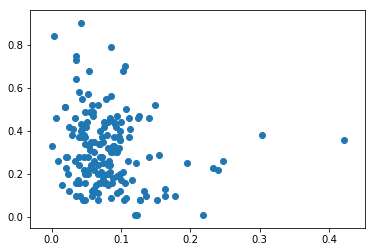

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
X = data_for_analize['kno']
Y = y
plt.scatter(X,Y)

In [80]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score

x_train, x_hold, y_train, y_hold = train_test_split(data_for_analize.values, y_r, test_size=0.3, random_state=17)

In [81]:
tree = DecisionTreeClassifier(max_depth=20, random_state=17)
tree.fit(x_train, y_train)
tree_pred = tree.predict(x_hold)
accuracy_score(y_hold, tree_pred)

0.29411764705882354

In [82]:
from sklearn.model_selection import GridSearchCV, cross_val_score
count_vals = data_for_analize.shape[1]
tree_params = {'max_depth': range(1,30), 'max_features': range(1, count_vals)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(x_train, y_train)

Fitting 5 folds for each of 58 candidates, totalling 290 fits


D:\libs\Anaconda\3.3\envs\aind\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[Parallel(n_jobs=-1)]: Done 290 out of 290 | elapsed:    1.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 30), 'max_features': range(1, 3)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [83]:
tree_grid.best_params_

{'max_depth': 1, 'max_features': 1}

In [84]:
tree_grid.best_score_

0.25423728813559321

In [85]:
accuracy_score(y_hold, tree_grid.predict(x_hold))

0.35294117647058826